In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from PIL import Image
from nltk.translate import bleu_score

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

***

In [3]:
from src.utils.config import IMAGES_DIR
from src.utils.sets import (
    init_image_descriptions_map,
    load_set_images,
    init_image_descriptions_map_set,
    data_generator
)

from src.utils.image import load_image, load_image_embedding_map
from src.utils.sequence import clean, init_idx_word_map, init_word_idx_map

from src.nn import NeuralImageCaptioning, NICInference

***

## Understanding and formating the data

In [4]:
image2descriptions = init_image_descriptions_map()

image2descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [5]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [6]:
for img_name, descriptions in image2descriptions.items():
    image2descriptions[img_name] = [clean(descr) for descr in descriptions]

In [7]:
image2descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [8]:
vocabulary = set()

for key in image2descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image2descriptions[key]]

In [9]:
vocabulary.update('0')
vocabulary.update(['<START>'])
vocabulary.update(['<END>'])

In [10]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [11]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [12]:
word2idx = init_word_idx_map(vocabulary)
idx2word = init_idx_word_map(vocabulary)

In [13]:
word2idx['dog']

2224

In [14]:
idx2word[2224]

'dog'

***

## Max Description Length

In [15]:
descriptions = []

for key, val in image2descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [16]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [17]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [18]:
train_images = load_set_images('train')
dev_images = load_set_images('dev')
test_images = load_set_images('test')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


### Init Image->Descriptions Maps Sets

In [19]:
train_image2descriptions = init_image_descriptions_map_set(train_images, image2descriptions)
dev_image2descriptions = init_image_descriptions_map_set(dev_images, image2descriptions)
test_image2descriptions = init_image_descriptions_map_set(test_images, image2descriptions)

print('Train size: {}'.format(len(train_image2descriptions)))
print('Dev size: {}'.format(len(dev_image2descriptions)))
print('Test size: {}'.format(len(test_image2descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [20]:
train_image2descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

## Creating Image-Embedding Maps

In [21]:
train_image2embedding = load_image_embedding_map('train', train_image2descriptions)

"train" Image-Embedding Map loaded.


***

In [22]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = [256, 256]

***

# Model

![NIC_model](../../img/NIC.png)

In [23]:
neural_image_captioning = NeuralImageCaptioning(
    EMBEDDING_DIM, max_description_length, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
print(neural_image_captioning.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_embedding_input (InputLay (None, 2048)         0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
top_image_encoder (Model)       (None, 1, 300)       2405676     image_embedding_input[0][0]      
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 37, 8767)     5978899     sequence_input[0][0]             
                                                                 top_image_encoder[1][0]          
Total para

***

## Run

### Callbacks

In [25]:
filepath = '../weights/nic-weights.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=True)

callbacks = [checkpoint]

In [47]:
neural_image_captioning.model.load_weights('../weights/nic-weights.hdf5')

neural_image_captioning.model.compile(Adam(1e-5), loss='categorical_crossentropy')

In [ ]:
num_epochs = 1000
batch_size = 64
steps = (len(train_image2descriptions) * 5) // batch_size

train_data_generator = data_generator(
    train_image2descriptions,
    train_image2embedding,
    word2idx,
    batch_size,
    max_description_length,
    len(vocabulary),
)

neural_image_captioning.model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=steps,
    epochs=num_epochs,
    verbose=True,
    callbacks=callbacks,
)

Epoch 1/1000
199/468 [===========>..................] - ETA: 1:16 - loss: 1.8185

***

## Dev

In [28]:
inference = NICInference(neural_image_captioning, word2idx)

In [36]:
def show_img(path_to_img):
    img = Image.open(path_to_img)
    img.load()
    plt.imshow(np.asarray(img, dtype='int32'));

def evaluate(img_id, beam_width=3):
    print('Image ID: {}'.format(img_id))
    print('='*50)
    print()
    img = load_image(img_id)
    
    greedy_hypothesis = inference.greedy_search(img)
    beam_hypothesis = inference.beam_search(img, beam_width=beam_width)
    references = image2descriptions[img_id]

    print('Greedy Search: {}'.format(greedy_hypothesis))
    print('Beam Search: {}'.format(beam_hypothesis))
    print()
    
    print('BLEU score Greedy Search: {}'.format(bleu_score.sentence_bleu(references, greedy_hypothesis)))
    print('BLEU score Beam Search: {}'.format(bleu_score.sentence_bleu(references, beam_hypothesis)))
    print()
    
    print('Greedy Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, greedy_hypothesis)))
    print('Beam Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, beam_hypothesis)))
    
    show_img(IMAGES_DIR+img_id+'.jpg')

Image ID: 124881487_36e668145d

Greedy Search: a man in a blue jacket riding a bike down a dirt path
Beam Search: a mountain biker in the mountain

BLEU score Greedy Search: 0.7089871714546119
BLEU score Beam Search: 0.6103327843188205

Greedy Search Hypothesis Log Probabilty: -96.2315902709961
Beam Search Hypothesis Log Probabilty: -44.028846740722656


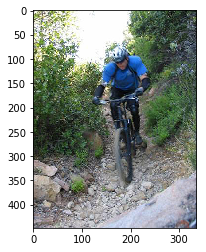

In [37]:

evaluate(
    np.random.choice(list(train_image2descriptions.keys())), beam_width=10
)

Image ID: 512306469_1392697d32

Greedy Search: a boy with a blue shirt is eating a green apple
Beam Search: a little boy is holding a toy

BLEU score Greedy Search: 0.5997079188357801
BLEU score Beam Search: 0.4255262126492552

Greedy Search Hypothesis Log Probabilty: -83.12257385253906
Beam Search Hypothesis Log Probabilty: -45.86528396606445


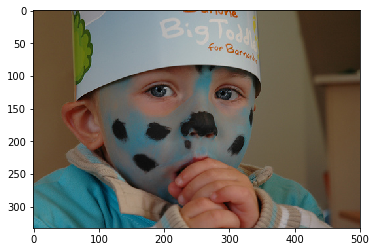

In [38]:
evaluate(
    np.random.choice(list(train_image2descriptions.keys())), beam_width=10
)

Image ID: 3549408779_4d453db080

Greedy Search: a black and white dog is swimming in a pool
Beam Search: a black and white dog swimming

BLEU score Greedy Search: 0.88891266806551
BLEU score Beam Search: 1.0

Greedy Search Hypothesis Log Probabilty: -81.19583129882812
Beam Search Hypothesis Log Probabilty: -45.08434295654297


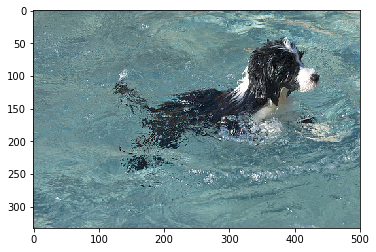

In [39]:
evaluate(
    np.random.choice(list(train_image2descriptions.keys())), beam_width=50
)

Image ID: 3090957866_f1b2b7f214

Greedy Search: a woman in a blue shirt and a woman in a black jacket and a brown jacket are walking down a sidewalk
Beam Search: a woman walking on a sidewalk

BLEU score Greedy Search: 0.6443143751009175
BLEU score Beam Search: 0.5886040523557469

Greedy Search Hypothesis Log Probabilty: -182.8592071533203
Beam Search Hypothesis Log Probabilty: -48.60944747924805


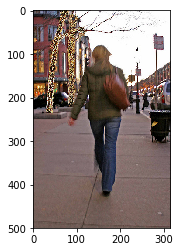

In [40]:
evaluate(
    np.random.choice(list(train_image2descriptions.keys())), beam_width=50
)

Image ID: 2151056407_c9c09b0a02

Greedy Search: a white dog inspects sheep while a woman watches
Beam Search: a white dog inspects sheep

BLEU score Greedy Search: 0.6922256154673514
BLEU score Beam Search: 0.6654057133025982

Greedy Search Hypothesis Log Probabilty: -52.770294189453125
Beam Search Hypothesis Log Probabilty: -24.16437339782715


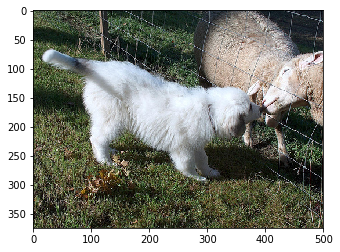

In [41]:
evaluate(
    np.random.choice(list(train_image2descriptions.keys())), beam_width=100
)

Image ID: 3576741633_671340544c

Greedy Search: a skateboarder in a green shirt is doing a jump
Beam Search: a boy in the air

BLEU score Greedy Search: 0.7228313727389422
BLEU score Beam Search: 0.20148163984308576

Greedy Search Hypothesis Log Probabilty: -71.57782745361328
Beam Search Hypothesis Log Probabilty: -39.847904205322266


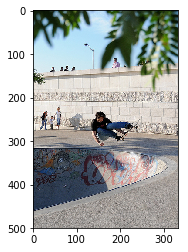

In [42]:
evaluate(
    np.random.choice(list(train_image2descriptions.keys())), beam_width=100
)

Image ID: 1378557186_4bd1da6834

Greedy Search: a brown and white dog is playing with a ball
Beam Search: a brown and white dog is trying to catch

BLEU score Greedy Search: 0.5570003187542448
BLEU score Beam Search: 0.5512118364608634

Greedy Search Hypothesis Log Probabilty: -80.39665222167969
Beam Search Hypothesis Log Probabilty: -76.79310607910156


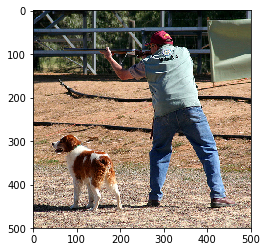

In [43]:
evaluate(
    np.random.choice(list(dev_image2descriptions.keys())), beam_width=100
)

Image ID: 3560081723_62da0035bd

Greedy Search: a person on a fourwheeler is in midair
Beam Search: two two wheeler on motorcycles

BLEU score Greedy Search: 0.7272494395173208
BLEU score Beam Search: 0.3959906783914369

Greedy Search Hypothesis Log Probabilty: -55.643089294433594
Beam Search Hypothesis Log Probabilty: -31.523456573486328


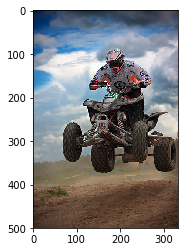

In [44]:
evaluate(
    np.random.choice(list(dev_image2descriptions.keys())), beam_width=100
)

Image ID: 2460159430_71ab1aacfa

Greedy Search: a brown dog runs through a field
Beam Search: a brown dog runs through the grass

BLEU score Greedy Search: 0.9194353966999143
BLEU score Beam Search: 0.9265608116842791

Greedy Search Hypothesis Log Probabilty: -56.52994918823242
Beam Search Hypothesis Log Probabilty: -53.16716384887695


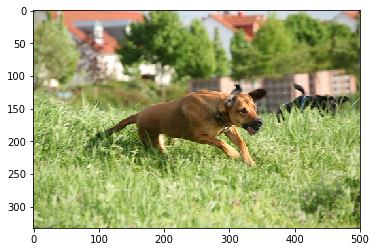

In [45]:
evaluate(
    np.random.choice(list(dev_image2descriptions.keys())), beam_width=100
)

Image ID: 1476241331_2f43b67aed

Greedy Search: a boy in a red shirt is standing in front of a house with a blue and blue striped wall
Beam Search: a young boys is swinging

BLEU score Greedy Search: 0.4140683350337539
BLEU score Beam Search: 0.29376984174355497

Greedy Search Hypothesis Log Probabilty: -158.5817108154297
Beam Search Hypothesis Log Probabilty: -34.18505096435547


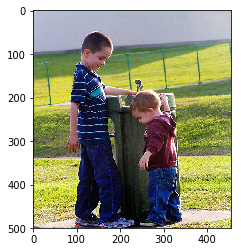

In [46]:
evaluate(
    np.random.choice(list(dev_image2descriptions.keys())), beam_width=100
)